In [ ]:
import torch

In [ ]:
ls

### 기본 pytorch 실습

In [ ]:

a = torch.ones(3)
a[1]

In [ ]:
float(a[1])

In [ ]:
a[2] = 2.0
a

In [ ]:
points = torch.zeros(6)
points[0] =  4.0
points[1] =  1.0
points[2] =  5.0

float(points[0]), float(points[1])

points = torch.tensor([[4.0,1.0], [5.0,3.0],[2.0,1.0]])
print(points)

In [ ]:
points.shape

In [ ]:
points = torch.zeros(3,2)
points

In [ ]:
points[0,1]

In [ ]:
points[0]

## 3.3 텐서 인덱싱

In [ ]:
# 만약 모든 포인트에서 첫번째 값만 구해야한다면 ?

some_list = list(range(6))
some_list[:]
some_list[1:4]
some_list[1:]
some_list[:4]
some_list[:-1]
some_list[1:4:2]

In [ ]:
points
points[1:]
points[1:, :]
points[1:, 0] # 첫번째이후 모든 행에 대해 첫번째 열만 포함
points[None] # 길이가 1인 차원 추가, unsqueeze와 동일

## 3-4 이름이 있는 텐서

In [ ]:
img_t = torch.randn(3,5,5)
weights = torch.tensor([0.2126, 0.7152, 0.0722])

In [ ]:
batch_t = torch.randn(2,3,5,5)

In [ ]:
img_gray_naive = img_t.mean(-3)
batch_gray_naive = batch_t.mean(-3)
img_gray_naive.shape, batch_gray_naive.shape
img_gray_naive, batch_gray_naive

In [ ]:
# 브로드 캐스팅
unsqueezed_weight = weights.unsqueeze(-1).unsqueeze_(-1)
img_weights = (img_t * unsqueezed_weight)
batch_weights= (batch_t * unsqueezed_weight)
img_gray_weighted = img_weights.sum(-3)
batch_gray_weighted = batch_weights.sum(-3)


batch_weights.shape, batch_t.shape, unsqueezed_weight.shape


In [ ]:
img_gray_weighted_fancy = torch.einsum('...chw, c-> hw', img_t, weights)
batch_gray_weighted_fancy = torch.einsum('...chw, c->...hw', batch_t, weights)
batch_gray_weighted_fancy

In [ ]:
weights_named = torch.tensor([0.2126, 0.7152,0.0722], names = ['channels'])
weights_named.shape

In [ ]:
img_named = img_t.refine_names(..., 'channels', 'rows', 'columns')
batch_named = batch_t.refine_names(..., 'channels', 'rows', 'columns')
print("img named:", img_named.shape, img_named.names)
print("batch named:", batch_named.shape, batch_named.names)

In [ ]:
print(weights_named.shape, weights_named.names)
weights_aligned = weights_named.align_as(img_named)
weights_aligned.shape, weights_aligned.names

In [ ]:
gray_named = (img_named * weights_aligned).sum('channels')
gray_named.shape, gray_named.names

In [ ]:
gray_named = (img_named[..., :3] * weights_named).sum('channels')


# 5장



## 5.4


In [ ]:
# 온도 문제
# 데이터 수집

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2 , 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [ ]:
def model(t_u,w,b):
    return w*t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean() # mean square error

w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u,w,b)
t_p

# 손실값을 체크해보자
loss = loss_fn(t_p, t_c)
loss


# 손실이 최소일 때의 W, b를 어떻게 추정할 것인가?
# 브로드 캐스팅
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)
print(f"x : {x.shape}, y:{y.shape}")
print(f"z: {z.shape}, a:{a.shape}")
print("x*y :",(x*y).shape)
print("y*z :", (y*z).shape)

print("y*z*a :",(y*z*a).shape)

### 미분 함수 정의하기

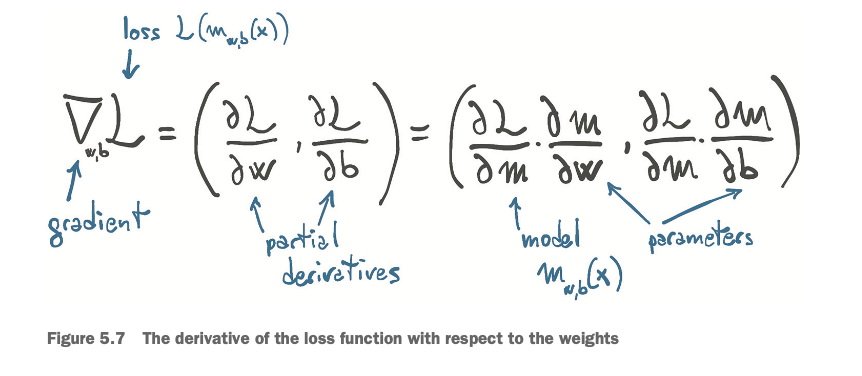

In [ ]:
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u,w +delta, b), t_c)) - loss_fn(model(t_u, w-delta,b),t_c) / (2.0 *delta) # 수치 미분 , 기울기를 의미함


learning_rate =1e-2 # 얼마만큼 바꿔갈 것인가
w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = (loss_fn(model(t_u, w, b+delta), t_c) - loss_fn(model(t_u, w,b-delta),t_c)) /( 2.0*delta)
b = b - learning_rate * loss_rate_of_change_b

def loss_fn(t_p,t_c):
    squared_diffs = (t_p - t_c) **2
    return squared_diffs.mean()


# 파라미터에 대한 손실 함수의 미분 -> d loss_fn / d w = (d loss_fn / d t_p) * (d t_p / d w)


# 1. (d loss_fn / d t_p)
# d x^2 / d x = 2x 를 이용하자

def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) #  t_p.size(0) : 평균을 내기 위해 전체 개수로 나눠줌

    return dsq_diffs

# 2. (d t_p / d w)
def model(t_u,w,b):
    return  w * t_u + b

def dmodel_dw(t_u,w,b):
    return t_u
def dmodel_db(t_u,w,b):
    return 1.0

# 경사함수 정의하기 - w와 b에 대한 손실값의 미분을 반환하는 함수

def grad_fn(t_u,t_c, t_p,w,b):
    dloss_dtp = dloss_fn(t_p,t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w,b) # w 파라미터 - 손실 함수 미분 값
    dloss_db = dloss_dtp * dmodel_db(t_u, w,b) # b 파라미터 - 손실함수 미분 값
    stack = torch.stack([dloss_dw.sum(), dloss_db.sum()])
    print(f'stack : {stack}')
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

'''
sum()을 해주는 이유 :
각 데이터별로 계산된 gradient를 모두 더해서, 파라미터($w$, $b$)별로 하나의 최종 gradient(스칼라 값)를 만들기 위해서

dloss_dw와 dloss_db는 각각 모든 데이터 포인트에 대해 계산된 gradient(기울기) 값들의 벡터(또는 텐서)야.

경사하강법에서 파라미터를 업데이트할 때는, **전체 데이터에 대한 gradient의 합(혹은 평균)**을 사용해 한 번에 파라미터를 업데이트해.

즉, 각 데이터별로 구한 gradient를 모두 더해서 최종적으로 한 개의 스칼라 값(각 파라미터별)로 만들어야 해.

'''

### 5.4.3 모델 적합을 위한 반복

In [ ]:
# 훈련 루프
def training_loop(n_epochs, learning_rate, params , t_u, t_c):
    for epoch in range(1, n_epochs+1):
        w,b = params

        t_p = model(t_u, w,b)  # <- 순방향 전달
        loss = loss_fn(t_p , t_c)
        grad = grad_fn(t_u, t_c, t_p, w,b) # <- 역방향 전달
        print(f'grad : {grad}')
        params = params - learning_rate * grad

        print('Epoch %d , Loss  %f' % (epoch, float(loss)))
    return params

# 이제 훈련 루프를 실행해보자
training_loop(
    n_epochs= 100,
    learning_rate=1e-2,
    params = torch.tensor([1.0,0.0]),
    t_u = t_u,
    t_c = t_c
)


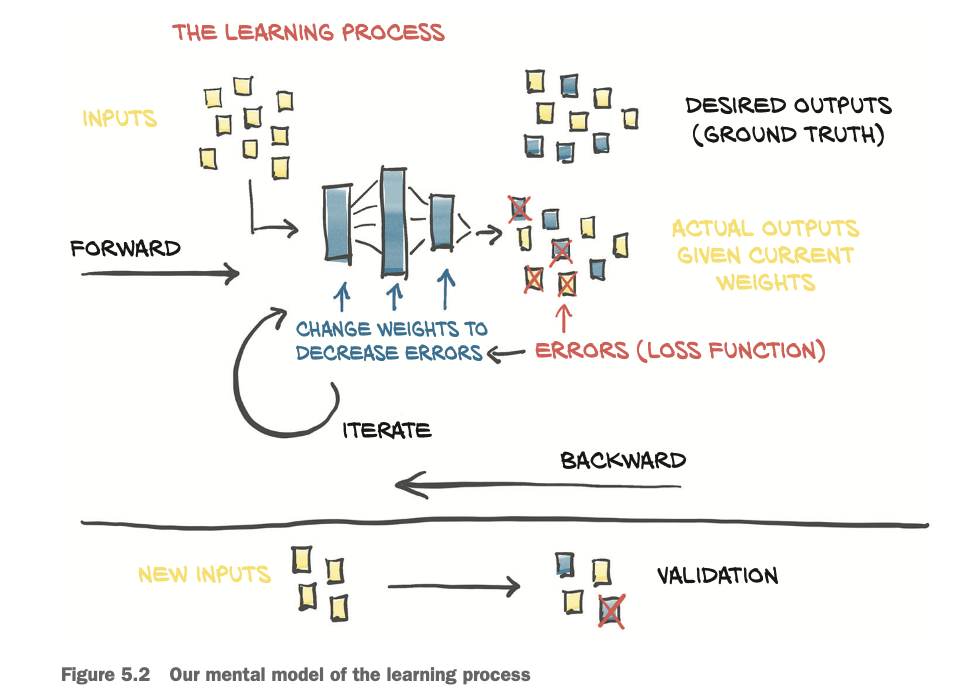

### 어떻게 하면 learning_rate * grad 규모를 적절하게 제한할 수 있을까?

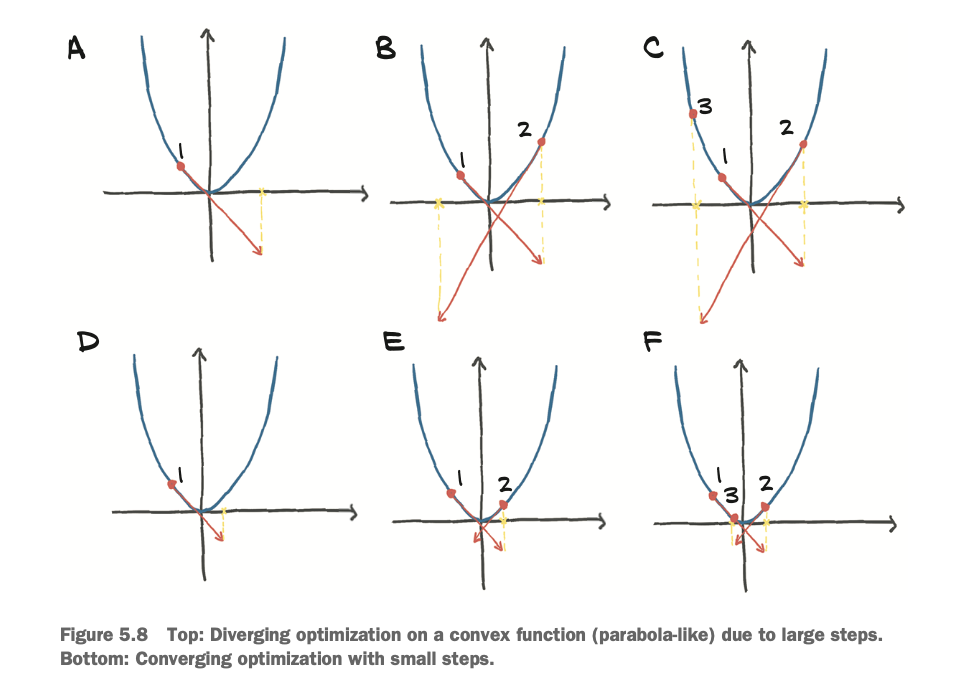

### 사실은 쉽다. learning_rate 값이 작으면 된다.
- 학습률은 우리가 기대한 대로 학습이 되지 안흥ㄹ 대 일반적으로 바꿔볼 수 있는 값 중 하나이다.
- 1e-3이나 1e-4로 시작해서 변화량의 자릿수를 줄여나간다.

In [ ]:
training_loop(
    n_epochs= 100,
    learning_rate=1e-4,
    params = torch.tensor([1.0,0.0]),
    t_u = t_u,
    t_c = t_c
)

### 잘 동작한다. 그러나 파라미터 조정이 너무 조금씩이라 손실이 너무 느리게 줄어들다가 멈춘다.

### 입력 정규화
- 첫 에포크에서 가중치에 대한 기울기가 편향값에 대한 기울기보다 50배나 크다.
- `grad : tensor([1859.5493,   35.7843])`
- 가중치와 편향값은 범위가 다르다는 이야기
- 이 때 입력값을 변경해서 기울기가 서로 큰 차이가 나지 않게  한다
- 입력값의 범위를 -1.0 ~ 1.0 사이로 해보자


In [ ]:
t_un = 0.1 * t_u

params = training_loop(
    n_epochs= 5000,
    learning_rate=1e-2,
    params = torch.tensor([1.0,0.0]),
    t_u = t_un,
    t_c = t_c
)

### 5.4.5 시각화

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p =  model(t_un, *params) # *params : params요소를 개별 인자로 전달한다는 의미 , model(t_un, params[0], params[1])과 동일

fig = plt.figure(dpi = 600)
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Temperature (Celsius)')
# plt.plot(t_u.numpy(), t_p.numpy())
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

### 파라미터 업데이트 후에는 ?
- 다음 에폭으로 이동
- 업데이트된 파라미터를 사용해서 다시 순방향 전달을 수행
- 즉, 새로운 파라미터로 모델이 예측을 다시 하게 되고, 손실을 다시 계산함.


## 5.5 파이토치의 자동 미분 : 모든 것을 역전파하라
- chain rule을 사용하여 미분을 역방향으로 전파하는 방법을 통해 w와 b를 내부 파라미터로 가지는 모델과 손실에 대한 합성하뭇를 계산했다.
- 전체 : 함수가 해석적으로 미분 가능해야한다는 것!
- 복잡한 선형과 비선형 합성 함수의 미분은 어렵다

### 5.5.1 기울기 자동 계산

In [ ]:
# 자동 미분 적용하기
def model(t_u, w,b):
 return w*t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) **2
    return squared_diffs.mean()

params = torch.tensor([1.0, 0.0], requires_grad= True)

# requires_grad : params에 가해지는 연산의 결과로 만들어지는 모든 텐서를 이은 전체 트리를 기록하라고 파이토치에게 요청하는 것
# 이 함수들이 미분 가능한 경우, 미분값은 params 텐서의 grad 속성에 기록된다.

params.grad is None # 일반적으로 None이다.

'''
값을 얻기 위해서는
1. 텐서를 만들 때 requires_grad = True로 지정
2. 모델을 호출해 손실값을 구한 다음 ,
3. loss 텐서에 대해 backward를 호출
'''

loss = loss_fn(model(t_u, *params),t_c)
loss.backward()  # 이전 기울기값에 누적되어 새로운 기울기 계산

params.grad  # tensor([4517.2969,   82.6000]) : params의 각 요소에 대한 손실값의 미분 포함



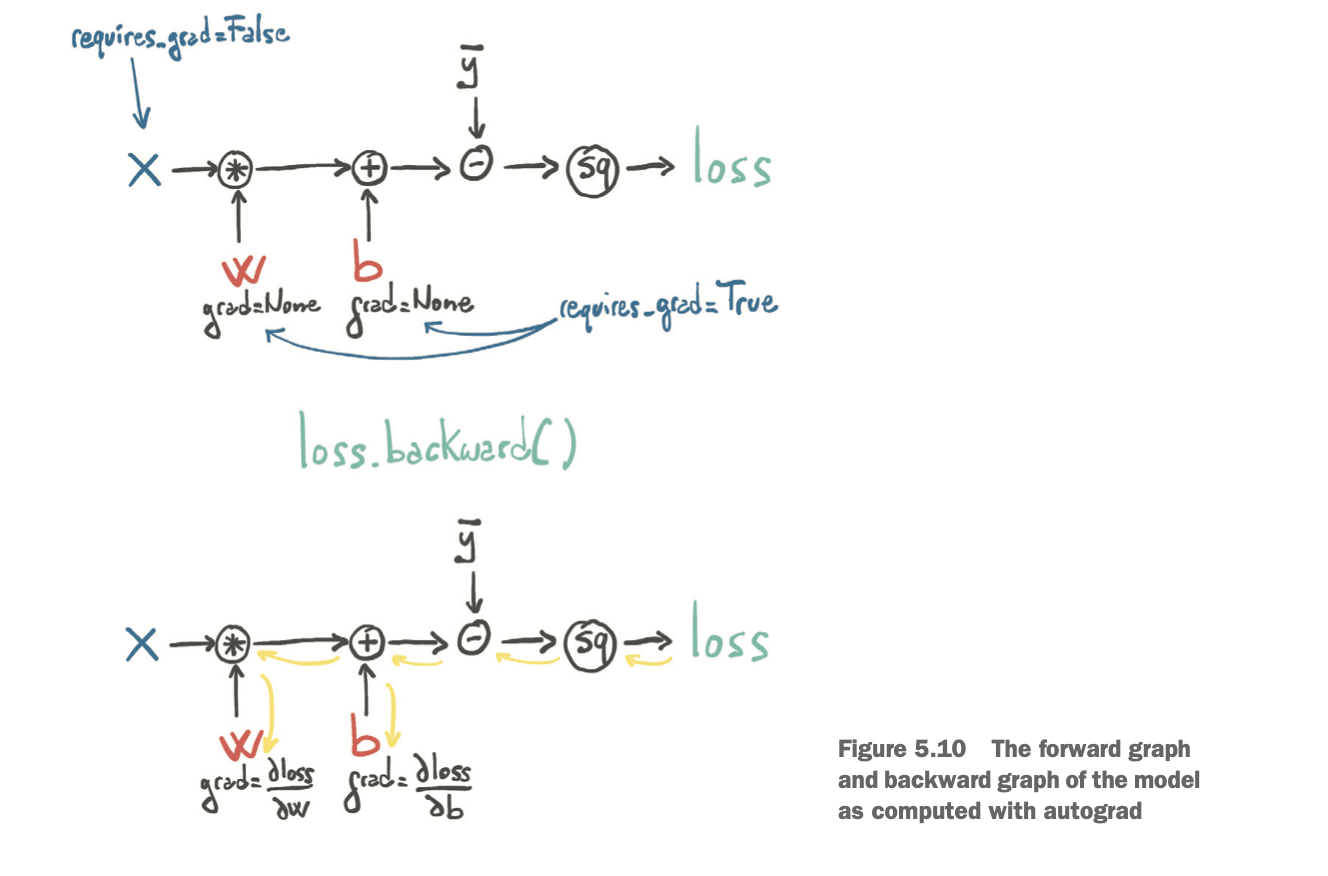

In [ ]:
# 미분 함수 누적하기
'''
파이토치는 연쇄적으로 연결된 함수들(computation graph)를 거쳐 손실에 대한 미분을 계산하고, 그 값을 텐서의 grad 속성에 누적한다.
backward()가 호출되면 , 말단 노드의 기울기 값이 이전 반복문 수행 시 계산되었던 기존값에 누적되어 부정확한 기울기값을 초래한다.

따라서 이를 방지하려면 각 반복문에서 명시적으로 기울기를 0으로 초기화해줘야한다.

'''

# 자동 미분을 적용한 훈련 코드

def training_loop(n_epochs, learning_rate, params , t_u, t_c):
    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)  # <- 순방향 전달
        loss = loss_fn(t_p , t_c)
        loss.backward()

        with torch.no_grad():  # 블록 안에서 파라미터를 업데이트한다. autograd이 파라미터 업데이트 과정을 추적하지 않게 하기 위해서
            params -= learning_rate  * params.grad
        if epoch % 500 ==0:
            print('Epoch %d, loss %f' % (epoch, float(loss)))
    return params

# training_loop(
#     n_epochs = 5000,
#     learning_rate = 1e-2,
#     params = torch.tensor([1.0,0.0], requires_grad = True),
#     t_u = t_un,
#     t_c = t_c
# )

# tensor([  5.3671, -17.3012], requires_grad=True) -> 아까 결과와 동일!!  이제 수동으로 미분할 필요가 없어졌다.

### 5.5.2 골라쓰는 옵티마이저
- 앞에서는 최적화를 위해 기본 버전의 경사 하강 사용
- 모델이 복잡해질 경우 사용할 수 있는 여러가지 최적화 전력과 기법

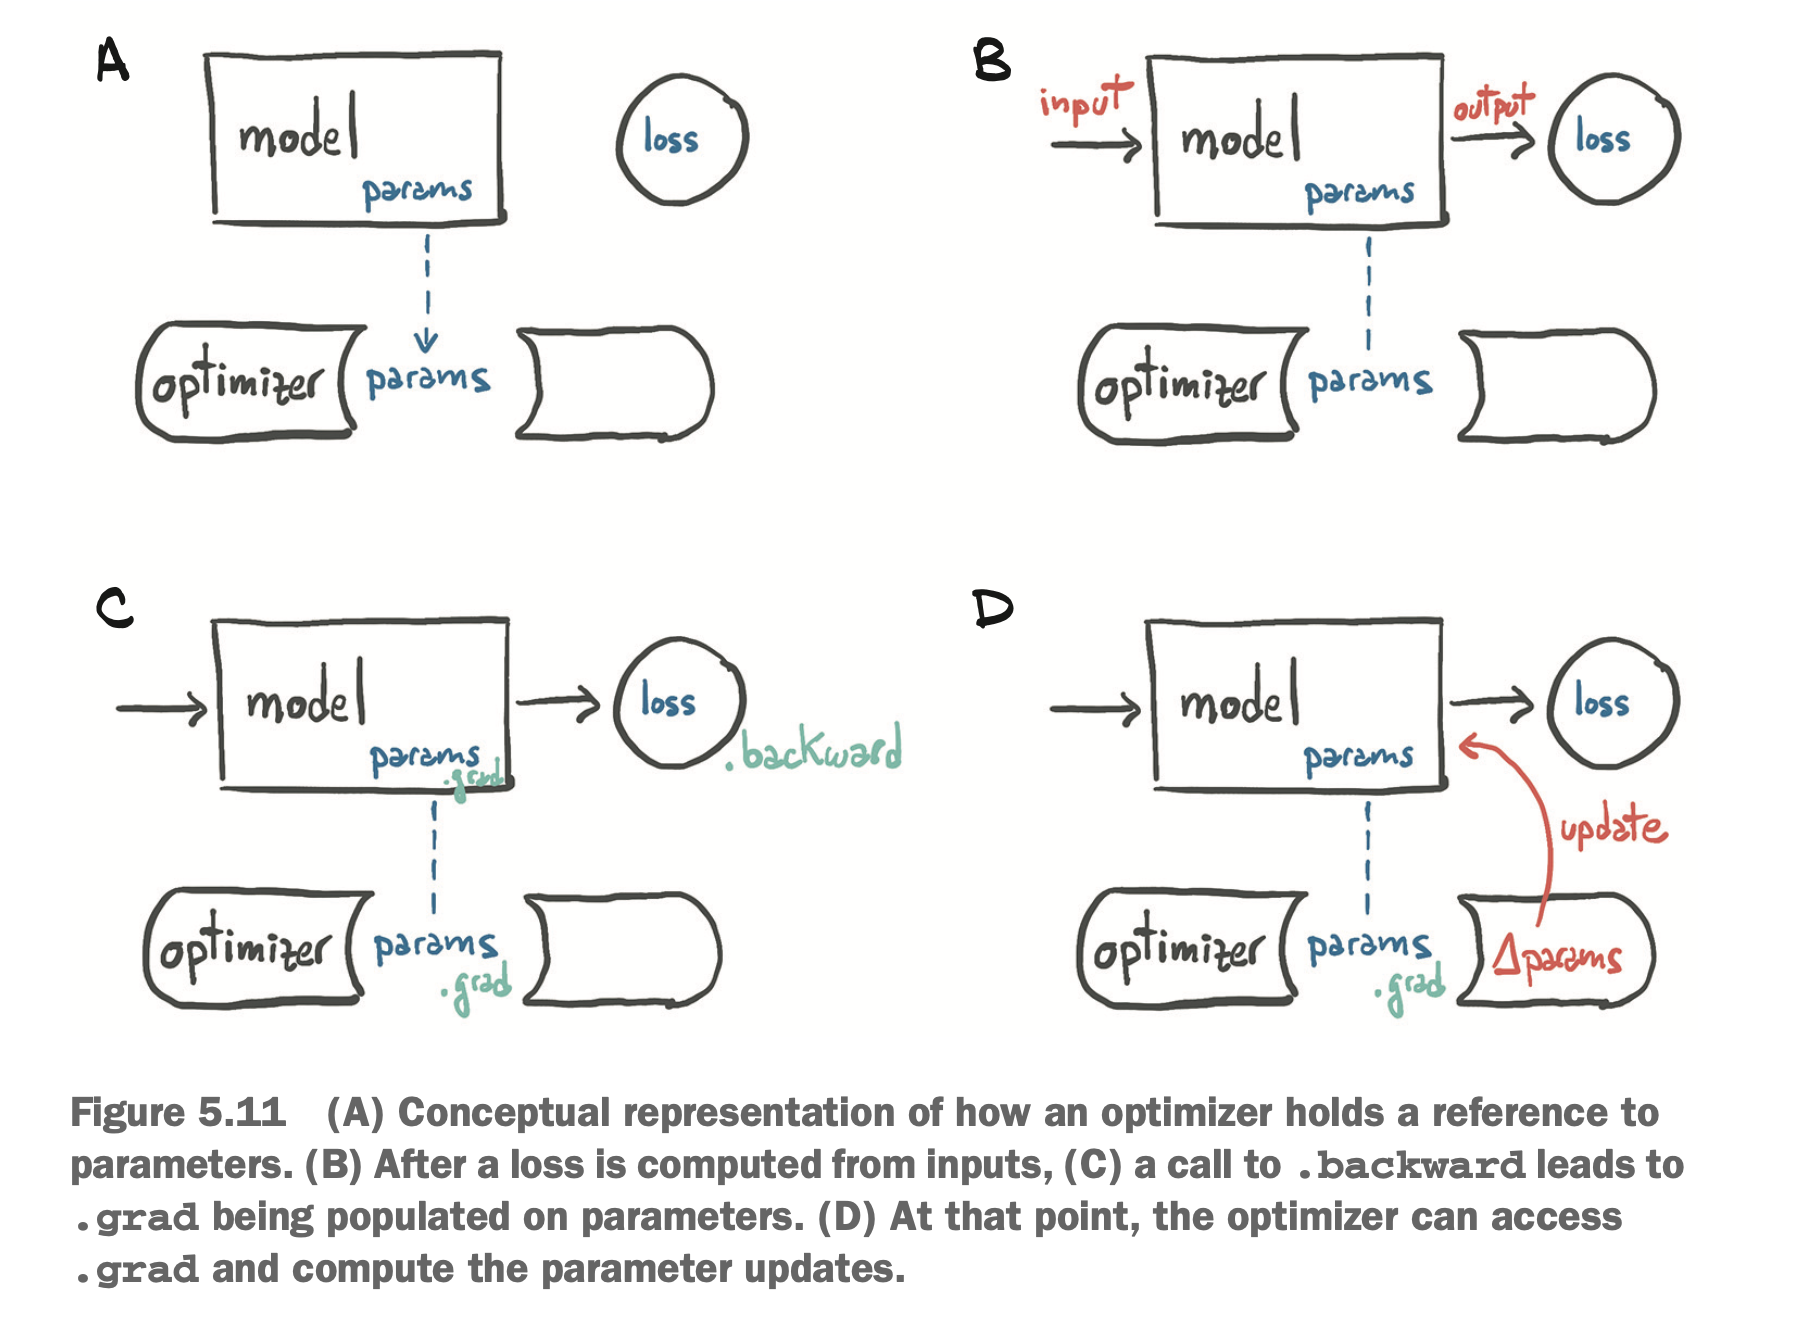

#### 위 그림은 Pytorch에서 Optimizer와 파라미터를 어덯게 참조하고 업데이트하는지 흐름을 알려준다.

A. Optimizer가 파라미터를 잡고 있는 상태
- Optimizer와 모델이 동일한 파라미터(params)를 참조
- 준비 단계

B. 입력 -> 모델 -> 출력(loss)계산 (순방향)
- 입력 데이터를 모델에 넣으면 출력이 나오고 손실(loss)이 계산된다.
- 이 상태에서도 Optimizer와 모델은 같은 파라미터를 공유하고 있음

C. loss.backward()호출 (역방향)
- loss.backward()를 호출하면 파라미터에 .grad 값이 채워져(각 파라미터별로 손실에 대한 미분값이 저장됨)
- 이제 Optimizer도 params.grad 정보를 사용 가능

D. Optimizer 파라미터 업데이트
- Optimier가 params와 params.grad 정보를 활용해 파라미터를 업데이트(Δparams)
- 이로서 파라미터 값이 바뀌고 다음 학습이 가능해진다.

In [ ]:
# 경사 하강 옵티마이저 사용하기

params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-5

optimizer = torch.optim.SGD([params], lr= learning_rate)

t_p = model(t_u,*params)
loss = loss_fn(t_p , t_c)

optimizer.zero_grad()

loss.backward()

optimizer.step() # step : 옵티마이저별로 구현된 최적화전략에 따라 파라미터 값을 조정한다.

params # tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True) : step 호출을 통해 알아서 params가 조정됨.


# 훈련 루프를 고쳐보자

def training_loop(n_epochs, optimizer , learning_rate, params , t_u, t_c):
    for epoch in range(1, n_epochs+1):

        t_p = model(t_u, *params)  # <- 순방향 전달
        loss = loss_fn(t_p , t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 ==0:
            print('Epoch %d, loss %f' % (epoch, float(loss)))
    return params

params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-2
optimizer = torch.optim.SGD([params], lr= learning_rate)

# training_loop(
#     n_epochs = 5000,
#     optimizer = optimizer,
#     learning_rate = learning_rate,
#     params = params,
#     t_u = t_un,
#     t_c =t_c
# )


# 다른 옵티마이저 테스트하기
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-1
optimizer = torch.optim.Adam([params], lr= learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    learning_rate = learning_rate,
    params = params,
    t_u = t_u,
    t_c =t_c
)

## 5.5.3 훈련 , 검증 , 과적합

In [ ]:
# 훈련 손실 평가하기
'''
 모델이 훈련셋에 얼마나 잘 맞춰졌는지, 모델이 데이터에 있는 필요한 정보를 찾아 처리하기에 충분한지를 알려준다.

'''

# 검증셋으로 일반화하기

# 데이터셋 나누기
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples) # 전체 데이터의 20% , 여기서는 2

shuffled_indices = torch.randperm(n_samples) # randperm : 0~n 사이의 정수를 무작위로 섞어서 텐서 만들기

train_indices = shuffled_indices[n_val:] # 2,3,4,5,6,7,8,9 10
val_indices = shuffled_indices[:n_val] # 0, 1

train_indices, val_indices

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u



def training_loop(n_epochs, optimizer , params , train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs+1):

        train_t_p = model(train_t_u, *params)  # <- 순방향 전달
        train_loss = loss_fn(train_t_p , train_t_c)


        with torch.no_grad():
            val_t_p = model(val_t_u, *params)  # <- 순방향 전달
            val_loss = loss_fn(val_t_p , val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward() # 검증 데이터로는 학습하면 안되므로 val_loss.backward()는 없다.
        optimizer.step()

        if epoch <= 3 or epoch % 500 ==0:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f},' f"Validation loss {val_loss.item():.4f}")
    return params


params = torch.tensor([1.0, 0.0],requires_grad= True)
learning_rate = 1e-2
optimizer = torch.optim.SGD([params],lr = learning_rate)

training_loop(
    n_epochs =3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c

)


def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)  # <- 순방향 전달
        loss = loss_fn(t_p , t_c)
    return loss

## 5.7 연습 문제

### Redefine the model to be w2 * t_u ** 2 + w1 * t_u + b.

a. What parts of the training loop, and so on, need to change to accommodate
this redefinition?

b. What parts are agnostic to swapping out the model?

c. Is the resulting loss higher or lower after training?

d. Is the actual result better or worse?


In [ ]:
# 모델을 다시 정의하자
def model2(t_u,w1, w2, b):
    return w2*t_u**2 + w1*t_u + b

# 이 모델을 다루기 훈련 루푸의 어떤 부분을 변경해야하나?
params2 = torch.tensor([2.0, 1.0, 0.0], requires_grad = True)

def training_loop(n_epochs, optimizer , params2 , train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs+1):

        train_t_p = model2(train_t_u, *params2)  #
        train_loss = loss_fn(train_t_p , train_t_c)


        with torch.no_grad():
            val_t_p = model2(val_t_u, *params2)  # <- 순방향 전달
            val_loss = loss_fn(val_t_p , val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward() # 검증 데이터로는 학습하면 안되므로 val_loss.backward()는 없다.
        optimizer.step()

        if epoch <= 3 or epoch % 500 ==0:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f},' f"Validation loss {val_loss.item():.4f}")
    return params

learning_rate = 1e-2
optimizer = torch.optim.SGD([params2], lr = learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params2 = params2,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c
)

# 훈련 후 손실은 감소했다.
# 실제 결과는 거의 비슷하다